<a href="https://colab.research.google.com/github/riteshcanfly/Python-AI-book/blob/master/Modeling_and_Prediction_in_Pytorch_boston_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pytorch is by default in Colab
import the other important libraries

In [0]:
import torch
import numpy as np
import seaborn as sns
import urllib
import pandas as pd
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
RECIPE_ID = "RECIPE-4"


import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Aim is to predict median house values in Californian districts, given a number of features from these districts.
Download the data as in the previous recipe and perform some preprocessing following these steps
* Looking at the big picture

* Data collection 

* Data visualization 

* Data discovery in order to gain insights 

* Data preparation for Machine Learning algorithms 

* Model selection and training 

* Fine-tuning the model

* Solution representation

* Launch, monitor, and maintain your system



In [0]:
from sklearn.datasets import fetch_openml
data = fetch_openml (data_id=531, return_X_y=False)
print(data.DESCR)
print(data.feature_names)
data_boston = pd.DataFrame(data.data, columns=data.feature_names)
data_boston['MEDV'] = data.target

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

In [0]:
data_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


Some descriptive statistics could be useful
mean, std, percentile etc.

In [0]:
data_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,4.636364,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,2.443456,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,0.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,3.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,4.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,8.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,8.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Understand the data a bit plot histograms to observe

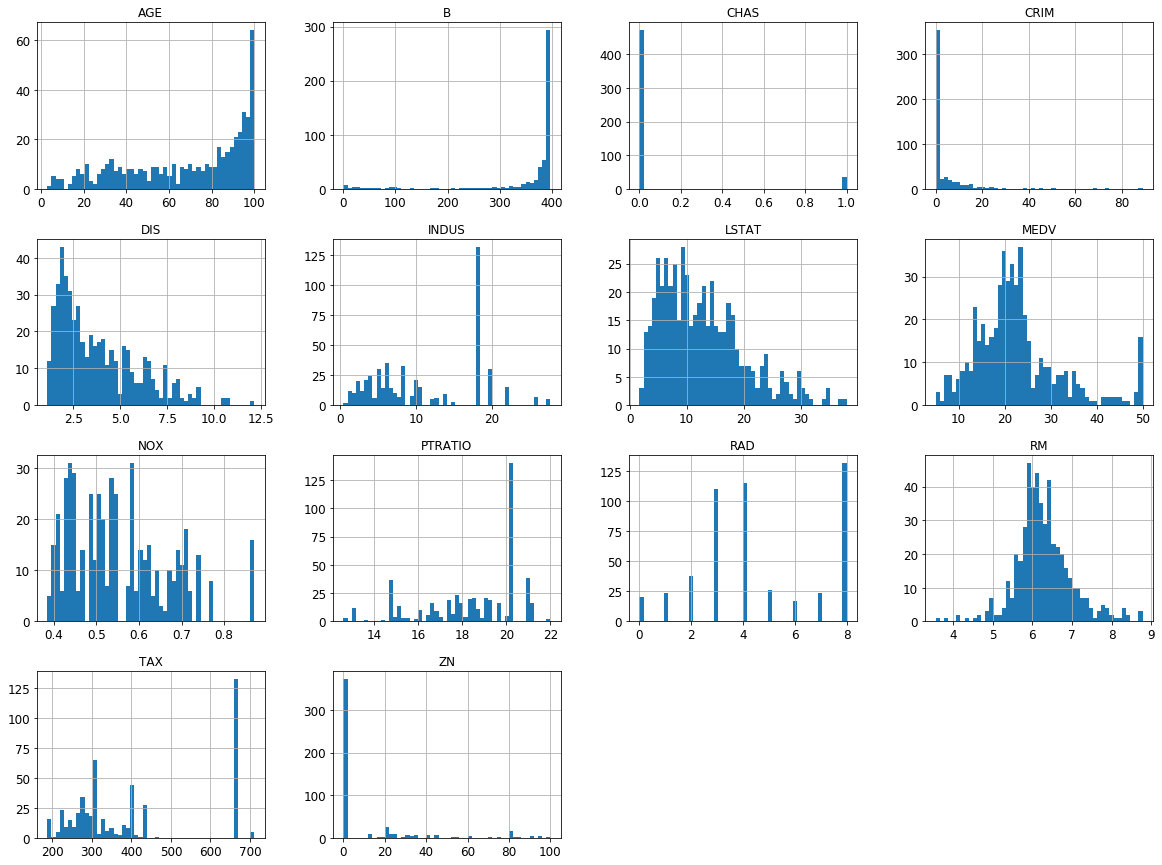

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
data_boston.hist(bins=50, figsize=(20,15))
plt.show()


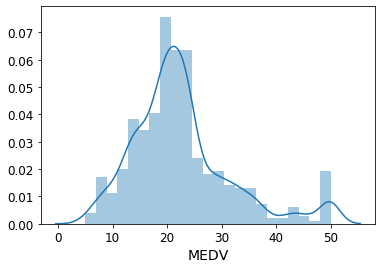

In [0]:
sns.distplot(data_boston['MEDV'])

In [0]:
corr = data_boston.corr()
# correlation with house values
corr['MEDV'].sort_values()

LSTAT     -0.737663
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
AGE       -0.376955
RAD       -0.290602
CHAS       0.175260
DIS        0.249929
B          0.333461
ZN         0.360445
RM         0.695360
MEDV       1.000000
Name: MEDV, dtype: float64

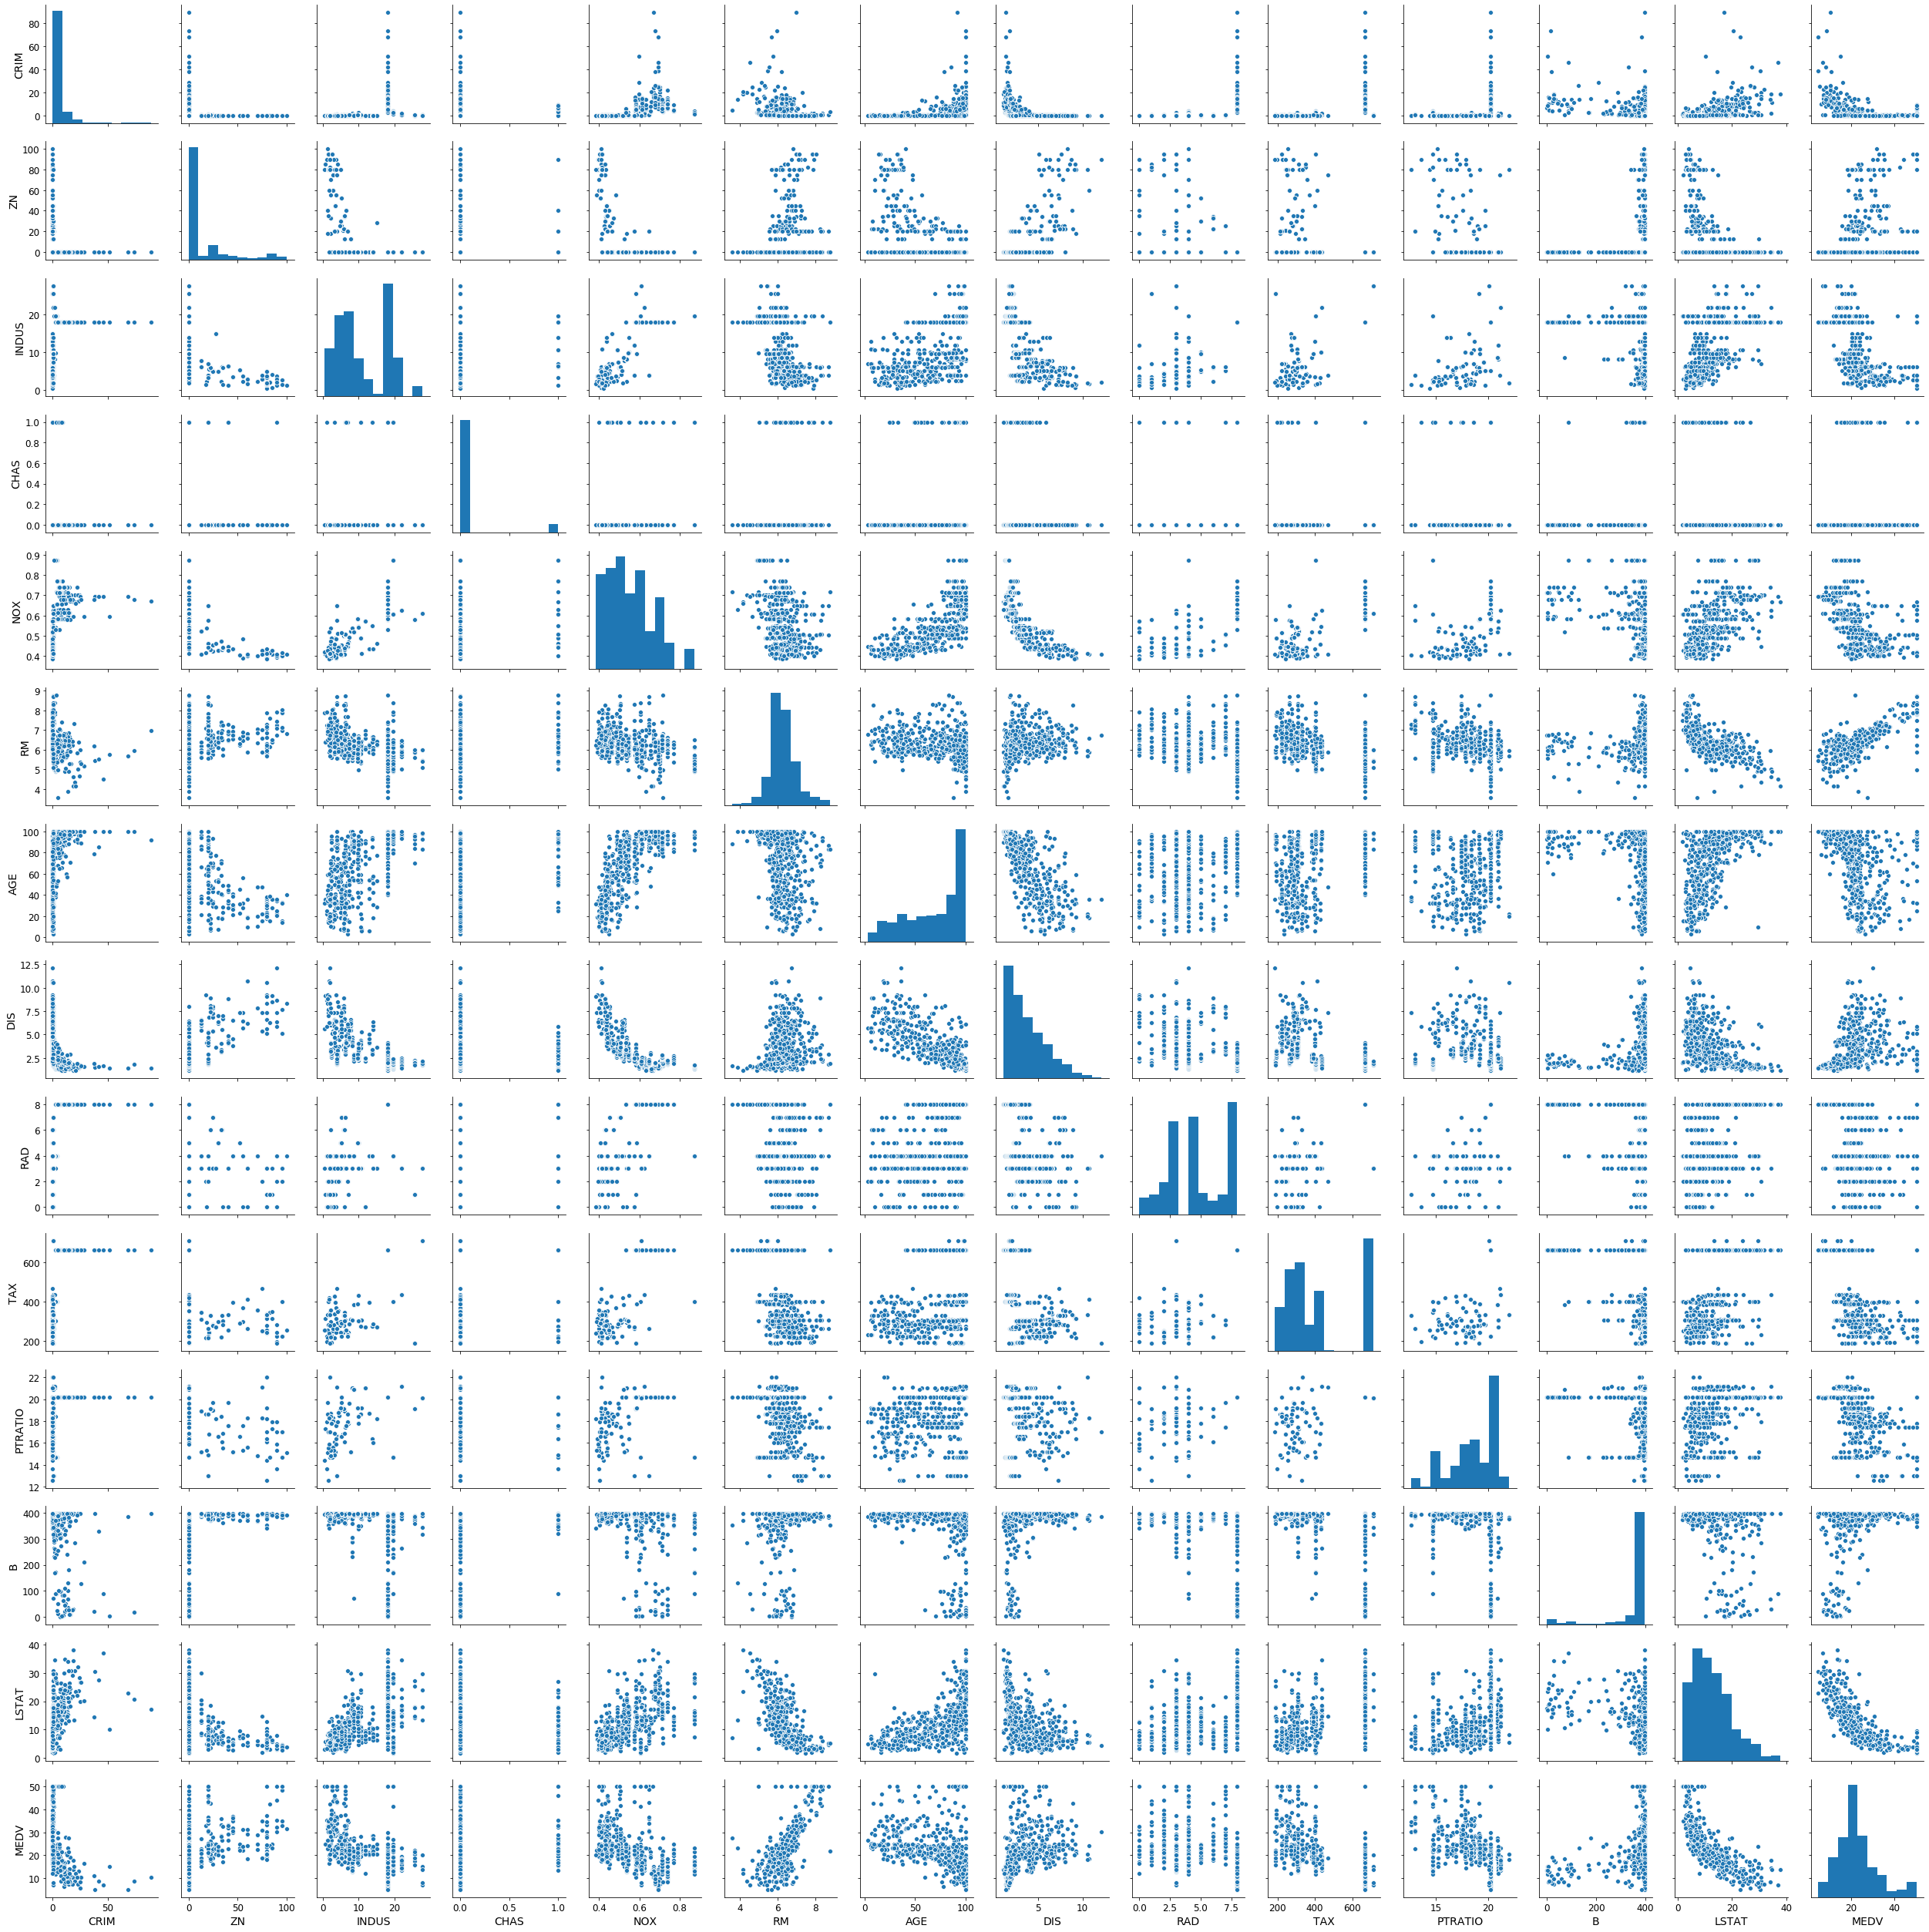

In [0]:
# pairplot

g = sns.pairplot(data_boston,  palette='husl' )


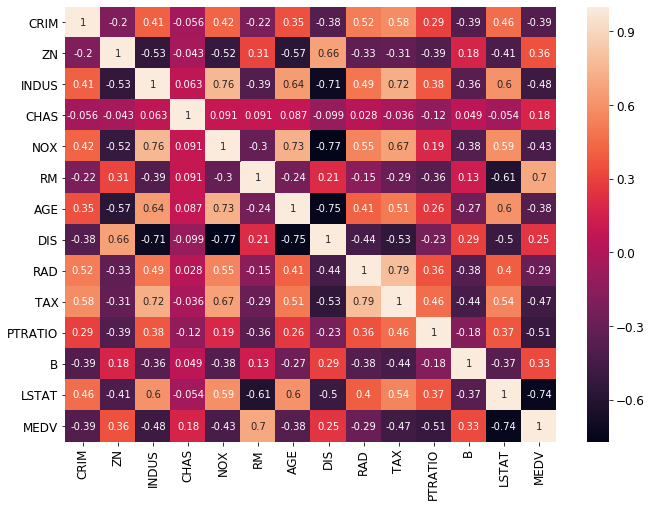

In [0]:
plt.figure(figsize=(11, 8))
sns.heatmap(data=corr, annot=True)


The correlation plot shows some interesting and some obvious things
* RM-Average number of rooms is strongly correlated with MEDV i.e. the price 
* LSTAT-The percentage lower status of population is negatively correlated with MEDV
*  Some features are coorealted with each other such as 
 -  RAD-index of accessibility to radial highways and TAX-full-value property-tax rate per $10,000
 - DIS-weighted distances to five Boston employment centres to AGE-proportion of owner-occupied units built prior to 1940 and NOX-nitric oxides concentration (parts per 10 million)


# Prepare the data for Machine Learning algorithms

* Data cleaning
    * Separate predictors and the label
    * Missing values
        * Get rid of the corresponding values.
        * Get rid of the whole attribute.
        * Set the values to some value (zero, the mean, the median, etc.).
            * If imputation is chosen, the median or other statistic should be computed on the training set as it will be used to fill the missing values in the training set, it should be saved. This will be needed later to replace missing values in the test set when the system evaluation is to be done and also once the system goes live to replace missing values in new data.

In [0]:
np.random.seed(12)
# train test splits could be done 
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_boston, test_size=0.2, random_state=12)


train = train_set.drop("MEDV", axis=1)  # drop labels for training set
train_labels = train_set["MEDV"].copy()

test = test_set.drop("MEDV", axis=1)
test_labels = test_set["MEDV"].copy()

**Stratx**

Stratx provides partial dependence and individual conditional expectaction plots on the codependent variables. 
It exposes a method called as StratPD. It does not depend on the user supplied model. The algorithm works by the stratification of the dataset into similar items. The change in the variable of interest or Y is explained due the variable aganist which it has been applied. 

Detailed mathematical explanations can be obtained from
https://arxiv.org/abs/1907.06698



In [0]:
!pip install stratx

  Created wheel for stratx: filename=stratx-0.1.3-cp36-none-any.whl size=13019 sha256=eaf6c91118df9d4f917b45b16f0ef7592b06588f3bca58e0f18ca2dea6e249bb
  Stored in directory: /root/.cache/pip/wheels/a3/60/33/85acf1922558bb53757bb3f8df47542ebfaf6299ee137db8ff
  Created wheel for dtreeviz: filename=dtreeviz-0.8.1-cp36-none-any.whl size=21790 sha256=9bc8c49d2259d44d70e9c8d88ff2496d2dd8de99015123ab5fa8c6872699cbd1
  Stored in directory: /root/.cache/pip/wheels/d8/74/06/0d9d450156c7cb2f1fcfb51a55b1542d26f459f557d742c406
Successfully built stratx dtreeviz


Text(0.5, 0.9, 'Model-independent partial dependence plot')

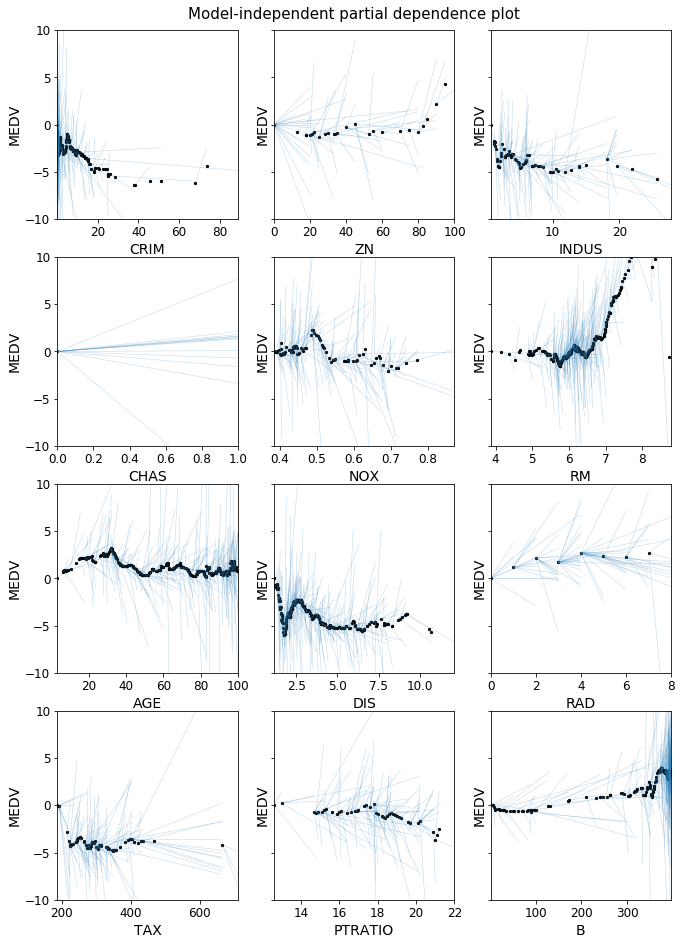

In [0]:
from stratx.partdep import *
fig, axs = plt.subplots(4, 3,  figsize= (11, 16), sharey=True)

for col, ax in zip(train.columns, axs.flat):
  plot_stratpd(train, train_labels, col, 'MEDV', yrange=(-10,10), ax=ax)

plt.suptitle('Model-independent partial dependence plot', x= 0.5, y=0.9, fontsize =15)


Clearly RM, DIS, TAX variables are more important because their fluctuations are more than the other variable with respect to the MEDV variable.

In [0]:
NA_rows = train[train.isnull().any(axis=1)].head()
NA_rows

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT


**Here** imputation is not chosen. An imputation instance of the scikit learn is created which can be used further downstream during model creation and evaluation.

In [0]:
# Perform One-Hot encoding of categorical values
train_cat = train[['RAD']]
train['RAD'].value_counts()


8.0    105
4.0     91
3.0     87
2.0     29
5.0     22
1.0     21
7.0     19
0.0     16
6.0     14
Name: RAD, dtype: int64

The RAD-index of accessibility to radial highways is restricted to 9 discreet values. This has been taken as categorical attribute. The binary variable CHAS is left as it is.


In [0]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
train_cat_1hot = cat_encoder.fit_transform(train_cat)
train_cat_1hot




/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

**Embeddings**

This section introduces the concept of embeddings. Embeddings are methods to map discrete-cateogorical variables to continuous vectors. In the context of neural networks, the embeddings are representation of values to lower dimensional representation using the Neural network architecture. 

PyTorch provides a method to convert the variable.  https://pytorch.org/docs/stable/nn.html#embedding

Here RAD varaible has been transformed into 3 dimensions and a neural network architecture is made on it.

The new transformation has been done by defining a new pipeline which works on the categorical variables. 

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmbeddingEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X):
        return self

    def transform(self, X):
        #print(X)
        X = X.values
        no_samples = X.shape[0]
        embedding_dim=3
        matrices = []
        for c in range(X.shape[1]):
          temp = torch.LongTensor(X[:,c])
          embedding  = torch.nn.Embedding(num_embeddings=9, embedding_dim=embedding_dim)
          torch_embedding = embedding(temp)
          np_embedding = torch_embedding.cpu().detach().numpy().reshape((no_samples,embedding_dim))
          matrices.append(np_embedding)
        res = np.concatenate(matrices, axis=0)
        return res

EmbeddingEncoder()

EmbeddingEncoder()

In [0]:
emd_encoder = EmbeddingEncoder()
train_cat_emd = emd_encoder.fit_transform(train_cat)
train_cat_emd

array([[ 0.23442361, -1.6536741 , -0.4392907 ],
       [ 0.0750389 ,  0.85552025,  1.3923974 ],
       [ 1.403622  , -0.33068115,  0.3372821 ],
       ...,
       [ 0.21342121, -0.4785214 ,  1.2556009 ],
       [ 0.23442361, -1.6536741 , -0.4392907 ],
       [ 0.0750389 ,  0.85552025,  1.3923974 ]], dtype=float32)

All of this can be transformed into a pipeline, scikit provides a pipeline mechanism. So the pipeline will have following workflow
* Normalization of the numerical attributes
* One hot encoding of categorical values

The columns 'INDUS', 'NOX', 'PTRATIO' and 'AGE' have skewness greater 0.3 and have been log transformed.

In [0]:



from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_attribs = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 
                     'AGE', 'DIS',  'TAX', 'PTRATIO', 'B', 'LSTAT']
categorical_attribs = ['RAD']

numerical_pipeline = Pipeline(steps = [
        ('normalise', StandardScaler()),
    ])

#categorical_pipeline = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
categorical_pipeline_emd = Pipeline(steps = [('nnembed', EmbeddingEncoder())])
preprocessor = ColumnTransformer([
        ("num_pipeline", numerical_pipeline, numerical_attribs),
        ("cat_pipeline", categorical_pipeline_emd, categorical_attribs),
    ])
train_prepared = preprocessor.fit_transform(train) 
test_prepared = preprocessor.fit_transform(test) 


In [0]:
train_prepared[0,:]

array([-0.32297305,  0.35561567, -1.03259832, -0.28322059,  0.81463397,
        1.05764976,  0.5456246 , -0.77578598, -0.86608193, -2.58014745,
        0.3043104 ,  0.27028707])

Implement a simple Linear Regression with batch inputs using PyTorch.

* Prepare the data (Convert into Torch Tensor)
* Define the model
* Define the loss criteria and optimizer
* Make a DataLoader for batches
* Implement the neural network 

In [0]:
X_train = train_prepared
Y_train = train_labels.values
X_test = test_prepared
Y_test = test_labels.values


In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(404, 15)
(404,)
(102, 15)
(102,)


In [0]:

from torch.autograd import Variable 

In [0]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float()).view(-1, 1)
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float()).view(-1, 1)


In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([404, 15])
torch.Size([404, 1])
torch.Size([102, 15])
torch.Size([102, 1])


In [0]:
class LinearRegressionModel(torch.nn.Module): 
  
    def __init__(self, input_sz): 
        super(LinearRegressionModel, self).__init__() 
        self.linear1 = torch.nn.Linear(input_sz, 10)
        self.act1 = torch.nn.ReLU() # Activation function for the first layer
        self.linear2 = torch.nn.Linear(10, 1)
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        y_pred = self.linear2(x)
        return y_pred

# house model 
house_model = LinearRegressionModel(input_sz = X_train.shape[1])


# All of this can be enacasptulated directly like this


```
house_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 5),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(5, 1),
    )

```



Define a loss criteria and the optimizer for the network. We have taken the mean square error as the losss (MSE) and stochastic gradient descent as our optimization algorithm. The following could be used as optimizers along with the parameters

```
opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.6)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.1)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.8, 0.98))

```

In [0]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(house_model.parameters(), lr = 0.001) 

Impelement a DataLoader to input a batch of data at a time. PyTorch provides a DataLoader for this

In [0]:
data_batch = torch.utils.data.TensorDataset(X_train, Y_train)
# let us have a batch size = 10
train_iter = torch.utils.data.DataLoader(data_batch, batch_size = 10, shuffle = True)

In [0]:
train_losses, test_losses  = [], [] 
for epoch in range(1000): 
  train_loss, test_loss  = 0, 0 
  for x_train,y_train in train_iter:
    # Forward pass: Predict y by passing x to the model 
    pred_ytrain = house_model(x_train) 
  
    # Compute and print loss 
    loss = torch.sqrt(criterion(pred_ytrain, y_train)) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    train_loss += loss.item()
    with torch.no_grad():
      house_model.eval()
      pred_ytest = house_model(X_test)
      test_loss += torch.sqrt(criterion(pred_ytest, Y_test))
                
    train_losses.append(train_loss/len(train_iter))
    test_losses.append(test_loss)

  if epoch %100 == 0 :
    print("Epoch: {}/{}.. ".format(epoch, 1000),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_iter)),
              "Test Loss: {:.3f}.. ".format(test_loss))

Epoch: 0/1000..  Training Loss: 23.763..  Test Loss: 1014.363.. 
Epoch: 100/1000..  Training Loss: 4.182..  Test Loss: 203.264.. 
Epoch: 200/1000..  Training Loss: 3.418..  Test Loss: 191.756.. 
Epoch: 300/1000..  Training Loss: 2.988..  Test Loss: 197.947.. 
Epoch: 400/1000..  Training Loss: 2.807..  Test Loss: 206.453.. 
Epoch: 500/1000..  Training Loss: 2.698..  Test Loss: 210.241.. 
Epoch: 600/1000..  Training Loss: 2.560..  Test Loss: 212.327.. 
Epoch: 700/1000..  Training Loss: 2.516..  Test Loss: 213.908.. 
Epoch: 800/1000..  Training Loss: 2.503..  Test Loss: 213.577.. 
Epoch: 900/1000..  Training Loss: 2.447..  Test Loss: 213.667.. 


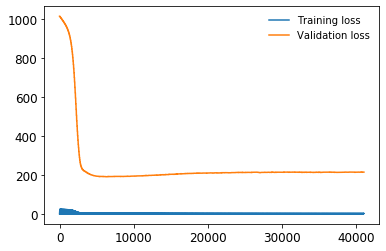

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

**CAPTUM**

Captum is a tool which can let us understand the in and out of the neural network model learnt on the datasets. 
It can help in learning 
* Feature importance
* Layer importance
* Neuron Importance

This is very important in learning interpretable Neural networks. Here, Integrated Gradients have been applied to understand ferature importance. Later Neuron importances have also been shown by using layer conductance method.
The details can be found in the original paper https://arxiv.org/pdf/1703.01365.pdf


In [0]:
!pip install captum

In [0]:
from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance

In [0]:
ing_house = IntegratedGradients(house_model)
X_test.requires_grad_()
attr, delta = ing_house.attribute(X_test,target=None, return_convergence_delta=True)
attr = attr.detach().numpy()

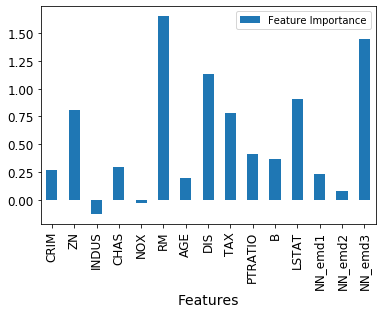

In [0]:
df_feat = pd.DataFrame(np.mean(attr, axis=0), columns=['Feature Importance'] )
captum_feat = list(train.columns)
captum_feat.remove('RAD')
captum_feat.extend(['NN_emd1', 'NN_emd2', 'NN_emd3'])
df_feat['Features'] = captum_feat
df_feat.plot.bar(x='Features', y='Feature Importance')


Clearly, RM turns out to be the most important feature along with DIS, TAX and one of our embeddings. Interestingly, RM, DIS were also observed to be the important features previously in the model independent partial dependeny plots.

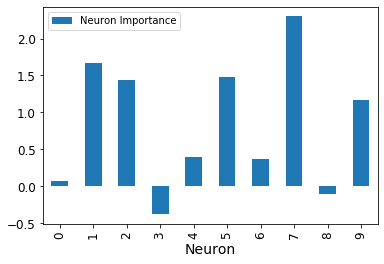

In [0]:
cond_layer1 = LayerConductance(house_model, house_model.act1)
cond_vals = cond_layer1.attribute(X_test,target=None)
cond_vals = cond_vals.detach().numpy()
df_neuron = pd.DataFrame(data = np.mean(cond_vals, axis=0), columns=['Neuron Importance'])
df_neuron['Neuron'] = range(10)
df_neuron.plot.bar(x='Neuron', y='Neuron Importance')

The figure shows the neuron importances. The neuron number 7 turns to be the most important one.